# POS Tagging Using RNN

The process of classifying words into their parts of speech and labeling them accordingly is known as part-of-speech tagging, or  POS-tagging. Common parts of speech in English are noun, verb, adjective, adverb, etc. One can consider this as a multi-class classification problem and apply a Logistic Regression model to tag the words. However, the problem with this approach is the ambiguity of the English language. In English, many common words have multiple meanings and therefore multiple POS. For example, the word "shot" can be a noun or a verb. The job of a POS tagger is to resolve this ambiguity accurately based on the context of use. Unlike Logistic Regression model, RNN models are capable of taking the context of a word into consideration. In this project we explore the application of several RNN models to POS tagging.

We will use conll2000 corpus for our explorations. The data we use can be found at http://www.cnts.ua.ac.be/conll2000/chunking/. We start with general imports.

In [ ]:
# general imports 
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Dense, Input, TimeDistributed
from keras.layers import LSTM, GRU, SimpleRNN, RNN
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from gensim.models import KeyedVectors

## Preprocess the data

The train and test data files have three columns separated by spaces. Each word has been put on a separate line and there is an empty line after each sentence. The first column contains the current word, the second its part-of-speech tag as derived by the Brill tagger and the third its chunk tag as derived from the WSJ corpus. We will use the first two columns.

We start preprocessing of data by dividing it into words and tags.

### Divide data into words and tags

We loop through each line of the data file. If the line is not empty, we split off word and tag and store them in currentX and currentY lists respectively. If the line is empty, we append currentX and currentY to Xtrain and Ytrain (Xtest and Ytest for the test data).

In [ ]:
# divide the train dataset into words and tags / features and labels
Xtrain = []
Ytrain = []
currentX = []
currentY = []
for line in open('/content/drive/MyDrive/NLP/Parts_of_speech_tagging/train.txt'):
    line = line.rstrip()
    if line:
      r = line.split()
      word, tag, _ = r
      currentX.append(word)
      currentY.append(tag)
    else:
      Xtrain.append(currentX)
      Ytrain.append(currentY)
      currentX = []
      currentY = []



In [ ]:
# divide the test data into words and tags / features and labels
Xtest = []
Ytest = []
currentX = []
currentY = []
for line in open('/content/drive/MyDrive/NLP/Parts_of_speech_tagging/test.txt'):
    line = line.rstrip()
    if line:
      r = line.split()
      word, tag, _ = r
      currentX.append(word)
      currentY.append(tag)
    else:
      Xtest.append(currentX)
      Ytest.append(currentY)
      currentX = []
      currentY = []

In [ ]:
num_words = len(set([word.lower() for sentence in Xtrain for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Ytrain for word in sentence]))
print("Total number of tagged sentences in training dataset: {}".format(len(Xtrain)))
print("Total number of tagged sentences in test dataset: {}".format(len(Xtest)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences in training dataset: 8936
Total number of tagged sentences in test dataset: 2012
Vocabulary size: 17258
Total number of tags: 44


Next we check whether the sets of tags for the train and test data are the same.

In [ ]:
Ytrain_pos = set([word.lower() for sentence in Ytrain for word in sentence])
Ytest_pos = set([word.lower() for sentence in Ytest for word in sentence])

In [ ]:
len(Ytrain_pos), len(Ytest_pos)

(44, 43)

In [ ]:
Ytrain_pos-Ytest_pos

{'sym'}

In [ ]:
for i in range(len(Ytrain)):
  for j in range(len(Ytrain[i])):
    if Ytrain[i][j].lower()=='sym':
      print(i,j)

1420 0
3423 0
3424 0
3425 0
3572 1
3573 1


In [ ]:
print(Ytrain[3572])
print(Xtrain[3572])

['NN', 'SYM', 'FW', '.']
['Pitcher', '=', 'lanzador', '.']


We found that the set of training labels contains one extra label, 'SYM", than the set of the test labels.

### Representing words and tags as numbers

To use a machine learning model we need to represent our data - inputs X and outputs Y - as numbers. We will use the built in Keras Tokenizer for this task. We fit our tokenizer on training data, and then use it to convert both train and test data to numbers.

In [ ]:
# encode X
word_tokenizer = Tokenizer() 
word_tokenizer.fit_on_texts(Xtrain) 
Xtrain_encoded = word_tokenizer.texts_to_sequences(Xtrain)
Xtest_encoded = word_tokenizer.texts_to_sequences(Xtest)

In [ ]:
# encode Y
tag_tokenizer = Tokenizer() 
tag_tokenizer.fit_on_texts(Ytrain) 
Ytrain_encoded = tag_tokenizer.texts_to_sequences(Ytrain)
Ytest_encoded = tag_tokenizer.texts_to_sequences(Ytest)


In [ ]:
# look at first encoded data point
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', Xtrain[0],  '\n')
print('Y: ', Ytrain[0],  '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', Xtrain_encoded[0], '\n')
print('Y: ', Ytrain_encoded[0], '\n')
print()
len(Xtrain[0]), len(Ytrain[0]), len(Xtrain_encoded[0]), len(Ytrain_encoded[0])

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Confidence', 'in', 'the', 'pound', 'is', 'widely', 'expected', 'to', 'take', 'another', 'sharp', 'dive', 'if', 'trade', 'figures', 'for', 'September', ',', 'due', 'for', 'release', 'tomorrow', ',', 'fail', 'to', 'show', 'a', 'substantial', 'improvement', 'from', 'July', 'and', 'August', "'s", 'near-record', 'deficits', '.'] 

Y:  ['NN', 'IN', 'DT', 'NN', 'VBZ', 'RB', 'VBN', 'TO', 'VB', 'DT', 'JJ', 'NN', 'IN', 'NN', 'NNS', 'IN', 'NNP', ',', 'JJ', 'IN', 'NN', 'NN', ',', 'VB', 'TO', 'VB', 'DT', 'JJ', 'NN', 'IN', 'NNP', 'CC', 'NNP', 'POS', 'JJ', 'NNS', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [1536, 7, 2, 1637, 15, 1106, 184, 5, 207, 246, 1146, 4973, 71, 481, 566, 9, 461, 1, 252, 9, 1750, 2555, 1, 4171, 5, 598, 6, 1309, 1537, 21, 736, 8, 549, 10, 6326, 8935, 3]

(37, 37, 37, 37)

### Pad sequences

To feed our data into an RNN model we need all sentences to have the same length. We find the maximal length of a sentence in our data and pad each sequence with zeros at the beginning to have the same length. We use Keras built in function pad_sequences for this purpose.

Find the maximal sentences length and pad all sentences to be that length.

In [ ]:
max_seq_length = max(len(x) for x in Xtrain + Xtest)
max_seq_length

78

In [ ]:
# pad sequences
Xtrain_padded = tf.keras.preprocessing.sequence.pad_sequences(Xtrain_encoded, maxlen=max_seq_length)
Ytrain_padded = tf.keras.preprocessing.sequence.pad_sequences(Ytrain_encoded, maxlen=max_seq_length)
Xtest_padded  = tf.keras.preprocessing.sequence.pad_sequences(Xtest_encoded,  maxlen=max_seq_length)
Ytest_padded  = tf.keras.preprocessing.sequence.pad_sequences(Ytest_encoded,  maxlen=max_seq_length)

# print the first sequence
print(Xtrain_padded[0], "\n"*3)
print(Ytrain_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 1536
    7    2 1637   15 1106  184    5  207  246 1146 4973   71  481  566
    9  461    1  252    9 1750 2555    1 4171    5  598    6 1309 1537
   21  736    8  549   10 6326 8935    3] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  4  1 16 11 15
 14 12  4  6  1  2  1  5  2  3  7  6  2  1  1  7 12 14 12  4  6  1  2  3
 13  3 22  6  5  8]


In [ ]:
# assign padded sequences to X and Y
Xtrain, Ytrain, Xtest, Ytest = Xtrain_padded, Ytrain_padded, Xtest_padded, Ytest_padded

### Vectorizing X and Y

Currently, each word and each tag is encoded as an integer.

We will use a more sophisticated technique to represent the input words (X) using what's known as word embeddings.

To represent each tag in Y, we use one-hot encoding scheme.

#### GLoVe embeddings for the input sequences X.

GloVe stands for Global Vectors for word representation. It is an unsupervised learning algorithm developed by researchers at Stanford University aiming to generate word embeddings by aggregating global word co-occurrence matrices from a given corpus.

In [ ]:
# load in pre-trained word vectors
word2vec = {}

with open('/content/drive/MyDrive/NLP/glove.6B/glove.6B.100d.txt', encoding='utf-8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec

In [ ]:
# assign word vectors from GLoVe model

EMBEDDING_SIZE  = 100  # each word in GLoVe model is represented using a 100 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2idx = word_tokenizer.word_index

# copy vectors from GLoVe model to the words present in corpus
for word, index in word2idx.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [ ]:
# check embedding dimension
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (17259, 100)


In [ ]:
# let's look at an embedding of a word
embedding_weights[word_tokenizer.word_index['have']]

array([ 1.57110006e-01,  6.56059980e-01,  2.11489992e-03, -6.51440024e-01,
       -2.84269989e-01, -2.03690007e-01, -7.75960013e-02,  4.07979995e-01,
       -3.44699994e-02, -1.63900003e-01, -2.15969995e-01,  3.41780007e-01,
        1.19599998e+00,  3.36389989e-01, -2.10759997e-01, -5.60150027e-01,
        1.50700003e-01,  3.49119991e-01, -9.71279979e-01,  1.81520000e-01,
        7.44080007e-01,  2.00289994e-01,  6.69860005e-01,  1.60850003e-01,
       -1.35070004e-03, -5.53919971e-01,  1.94110006e-01, -4.80430007e-01,
       -2.97769994e-01, -5.07650018e-01,  8.01639974e-01,  5.04239976e-01,
       -4.05239999e-01,  5.39910018e-01,  6.56859994e-01,  2.11400002e-01,
        1.85749993e-01,  8.06970000e-01, -2.00660005e-01,  9.57140028e-02,
       -5.88989973e-01, -3.59070003e-01,  2.71620005e-01, -5.17939985e-01,
        2.34699994e-01, -4.59990017e-02,  5.65010011e-01, -4.07469988e-01,
        6.33769989e-01, -9.22659993e-01, -2.34180000e-02, -2.50400007e-01,
       -1.95759997e-01,  

####  One-hot encoding for output sequences Y

Since Ytest has one less label than Ytrain, we specify the number of classes when encoding Ytest.

In [ ]:
# use Keras' to_categorical function to one-hot encode Y
Ytrain = to_categorical(Ytrain)
Ytest = to_categorical(Ytest, num_classes=45)

In [ ]:
Ytrain.shape, Ytest.shape

((8936, 78, 45), (2012, 78, 45))

### Split training data into training and validation sets

In [ ]:
# split training data into training and validation sets
VALID_SIZE = 0.15
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtrain, Ytrain, test_size=VALID_SIZE, random_state=4)

In [ ]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(Xtrain.shape))
print('Shape of output sequences: {}'.format(Ytrain.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(Xvalid.shape))
print('Shape of output sequences: {}'.format(Yvalid.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(Xtest.shape))
print('Shape of output sequences: {}'.format(Ytest.shape))

TRAINING DATA
Shape of input sequences: (7595, 78)
Shape of output sequences: (7595, 78, 45)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (1341, 78)
Shape of output sequences: (1341, 78, 45)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (2012, 78)
Shape of output sequences: (2012, 78, 45)


## Building and training our models.

As a benchmark we will use a multiclass logistic regression model. Since this model does not take word context into consideration, we expect it to struggle with words that can represent multiple parts of speech such as work, well, shot, etc. We, then, will improve on it with reccurent neural network models.

### Logistic Regression model

In [ ]:
# total number of tags
NUM_CLASSES = Ytrain.shape[2]

In [ ]:
# model 0
lr_model = Sequential()

# create embedding layer - usually the first layer in text problems
lr_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                          output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                          input_length  =  max_seq_length,          # length of input sequence
                          weights       = [embedding_weights],      # GLoVe word embedding
                          trainable     =  True                     # True - update the embeddings while training
))

# output is a dense layer with NUM_CLASSES nodes and activation softmax to perform classification of words as pos
lr_model.add(Dense(NUM_CLASSES, activation='softmax'))

In [ ]:
# compile model 0
lr_model.compile(loss =  'categorical_crossentropy',
                    optimizer =  'adam',
                    metrics   =  ['acc'])

In [ ]:
# check summary of the model
lr_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 78, 100)           1725900   
                                                                 
 dense (Dense)               (None, 78, 45)            4545      
                                                                 
Total params: 1,730,445
Trainable params: 1,730,445
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model 0
lr_training = lr_model.fit(Xtrain, Ytrain, batch_size=128, epochs=10, validation_data=(Xvalid, Yvalid))

Epoch 1/10
60/60 [==============================] - 4s 53ms/step - loss: 3.2166 - acc: 0.7655 - val_loss: 2.4354 - val_acc: 0.8450
Epoch 2/10
60/60 [==============================] - 3s 45ms/step - loss: 1.5267 - acc: 0.8808 - val_loss: 0.7621 - val_acc: 0.9106
Epoch 3/10
60/60 [==============================] - 3s 51ms/step - loss: 0.5325 - acc: 0.9278 - val_loss: 0.3942 - val_acc: 0.9398
Epoch 4/10
60/60 [==============================] - 4s 72ms/step - loss: 0.3192 - acc: 0.9520 - val_loss: 0.2716 - val_acc: 0.9551
Epoch 5/10
60/60 [==============================] - 3s 49ms/step - loss: 0.2253 - acc: 0.9646 - val_loss: 0.2073 - val_acc: 0.9627
Epoch 6/10
60/60 [==============================] - 3s 46ms/step - loss: 0.1722 - acc: 0.9710 - val_loss: 0.1698 - val_acc: 0.9678
Epoch 7/10
60/60 [==============================] - 3s 48ms/step - loss: 0.1390 - acc: 0.9749 - val_loss: 0.1460 - val_acc: 0.9704
Epoch 8/10
60/60 [==============================] - 4s 62ms/step - loss: 0.1167 - a

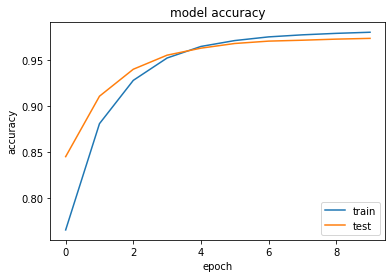

In [ ]:
# visualise training history
plt.plot(lr_training.history['acc'])
plt.plot(lr_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### RNN model

We will try the following two RNN models:

1. RNN with arbitrarily initialized, trainable embeddings: In this model, we will allow the network to train the word embeddings.

2. RNN with trainable GLoVe embeddings: In this experiment, we’ll use GLoVe word embeddings and also allow the network to train them further.

In [ ]:
# total number of tags
NUM_CLASSES = Ytrain.shape[2]

In [ ]:
# model 1
rnn_model_1 = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model_1.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                          output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                          input_length  =  max_seq_length,          # length of input sequence
                          trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model_1.add(SimpleRNN(64, 
              return_sequences=True 
))

# add time distributed (output at each sequence) layer
rnn_model_1.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [ ]:
# compile model 1
rnn_model_1.compile(loss =  'categorical_crossentropy',
                    optimizer =  'adam',
                    metrics   =  ['acc'])

In [ ]:
# check summary of the model
rnn_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 78, 100)           1725900   
                                                                 
 simple_rnn (SimpleRNN)      (None, 78, 64)            10560     
                                                                 
 time_distributed (TimeDistr  (None, 78, 45)           2925      
 ibuted)                                                         
                                                                 
Total params: 1,739,385
Trainable params: 1,739,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model 1
rnn_1_training = rnn_model_1.fit(Xtrain, Ytrain, batch_size=128, epochs=10, validation_data=(Xvalid, Yvalid))

Epoch 1/10
60/60 [==============================] - 9s 111ms/step - loss: 1.8266 - acc: 0.6516 - val_loss: 1.0847 - val_acc: 0.7072
Epoch 2/10
60/60 [==============================] - 8s 133ms/step - loss: 0.9379 - acc: 0.7836 - val_loss: 0.8164 - val_acc: 0.8090
Epoch 3/10
60/60 [==============================] - 6s 103ms/step - loss: 0.7043 - acc: 0.8329 - val_loss: 0.5818 - val_acc: 0.8686
Epoch 4/10
60/60 [==============================] - 8s 129ms/step - loss: 0.4740 - acc: 0.8992 - val_loss: 0.3848 - val_acc: 0.9207
Epoch 5/10
60/60 [==============================] - 6s 104ms/step - loss: 0.3024 - acc: 0.9410 - val_loss: 0.2555 - val_acc: 0.9484
Epoch 6/10
60/60 [==============================] - 8s 131ms/step - loss: 0.1955 - acc: 0.9641 - val_loss: 0.1821 - val_acc: 0.9625
Epoch 7/10
60/60 [==============================] - 6s 102ms/step - loss: 0.1337 - acc: 0.9754 - val_loss: 0.1405 - val_acc: 0.9700
Epoch 8/10
60/60 [==============================] - 8s 131ms/step - loss: 0.

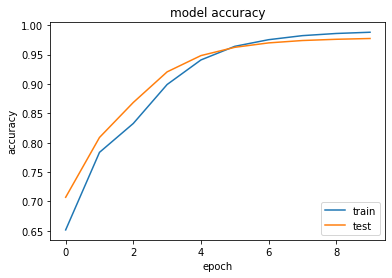

In [ ]:
# visualise training history
plt.plot(rnn_1_training.history['acc'])
plt.plot(rnn_1_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

Use pretrained word embeddings

In [ ]:
# model 2
rnn_model_2 = Sequential()

# create embedding layer 
rnn_model_2.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                          output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                          input_length  =  max_seq_length,          # length of input sequence
                          weights       = [embedding_weights],      # GLoVe word embedding matrix
                          trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model_2.add(SimpleRNN(64, 
              return_sequences=True  
))

# add time distributed (output at each sequence) layer
rnn_model_2.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [ ]:
# compile model 2
rnn_model_2.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [ ]:
# check summary of the model
rnn_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 78, 100)           1725900   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 78, 64)            10560     
                                                                 
 time_distributed_1 (TimeDis  (None, 78, 45)           2925      
 tributed)                                                       
                                                                 
Total params: 1,739,385
Trainable params: 1,739,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model 2
rnn_2_training = rnn_model_2.fit(Xtrain, Ytrain, batch_size=128, epochs=10, validation_data=(Xvalid, Yvalid))

Epoch 1/10
60/60 [==============================] - 9s 106ms/step - loss: 1.4527 - acc: 0.7459 - val_loss: 0.7558 - val_acc: 0.8346
Epoch 2/10
60/60 [==============================] - 8s 128ms/step - loss: 0.5912 - acc: 0.8756 - val_loss: 0.4515 - val_acc: 0.9065
Epoch 3/10
60/60 [==============================] - 6s 103ms/step - loss: 0.3578 - acc: 0.9299 - val_loss: 0.2856 - val_acc: 0.9454
Epoch 4/10
60/60 [==============================] - 8s 127ms/step - loss: 0.2254 - acc: 0.9578 - val_loss: 0.1915 - val_acc: 0.9620
Epoch 5/10
60/60 [==============================] - 6s 98ms/step - loss: 0.1511 - acc: 0.9707 - val_loss: 0.1408 - val_acc: 0.9707
Epoch 6/10
60/60 [==============================] - 7s 123ms/step - loss: 0.1102 - acc: 0.9774 - val_loss: 0.1130 - val_acc: 0.9746
Epoch 7/10
60/60 [==============================] - 7s 110ms/step - loss: 0.0862 - acc: 0.9814 - val_loss: 0.0961 - val_acc: 0.9773
Epoch 8/10
60/60 [==============================] - 7s 120ms/step - loss: 0.0

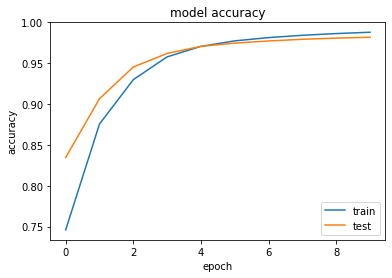

In [ ]:
# visualise training history
plt.plot(rnn_2_training.history['acc'])
plt.plot(rnn_2_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### GRU model

The RNN models are prone to vanishing or exploding gradients problem. To overcome these issues the researchers came up with two improved versions of RNN - LSTM and GRU. GRU being a simpler model than LSTM, is easier to train.  LSTMs and GRUs have almost completely replaced the standard RNNs in practice because they’re more effective and faster to train than vanilla RNNs (despite the larger number of parameters).

In [ ]:
# create a gru model
gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = max_seq_length,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [ ]:
# compile the gru model
gru_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

In [ ]:
# check summary of model
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 78, 100)           1725900   
                                                                 
 gru (GRU)                   (None, 78, 64)            31872     
                                                                 
 time_distributed_2 (TimeDis  (None, 78, 45)           2925      
 tributed)                                                       
                                                                 
Total params: 1,760,697
Trainable params: 1,760,697
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the gru model
gru_training = gru_model.fit(Xtrain, Ytrain, batch_size=128, epochs=10, validation_data=(Xvalid, Yvalid))

Epoch 1/10
60/60 [==============================] - 19s 240ms/step - loss: 1.9947 - acc: 0.7639 - val_loss: 0.7954 - val_acc: 0.8321
Epoch 2/10
60/60 [==============================] - 14s 230ms/step - loss: 0.6293 - acc: 0.8686 - val_loss: 0.4715 - val_acc: 0.9065
Epoch 3/10
60/60 [==============================] - 13s 218ms/step - loss: 0.3641 - acc: 0.9319 - val_loss: 0.2793 - val_acc: 0.9478
Epoch 4/10
60/60 [==============================] - 13s 217ms/step - loss: 0.2188 - acc: 0.9586 - val_loss: 0.1826 - val_acc: 0.9627
Epoch 5/10
60/60 [==============================] - 13s 220ms/step - loss: 0.1451 - acc: 0.9708 - val_loss: 0.1334 - val_acc: 0.9712
Epoch 6/10
60/60 [==============================] - 12s 206ms/step - loss: 0.1060 - acc: 0.9769 - val_loss: 0.1068 - val_acc: 0.9753
Epoch 7/10
60/60 [==============================] - 14s 234ms/step - loss: 0.0832 - acc: 0.9810 - val_loss: 0.0907 - val_acc: 0.9779
Epoch 8/10
60/60 [==============================] - 13s 224ms/step - 

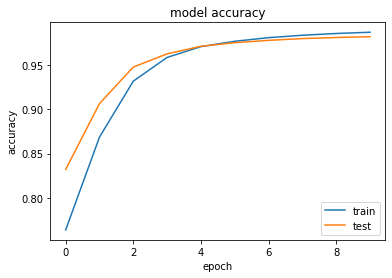

In [ ]:
# visualise training history
plt.plot(gru_training.history['acc'])
plt.plot(gru_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### LSTM model

In [ ]:
# create an LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = max_seq_length,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [ ]:
# compile the LSTM model
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

In [ ]:
# check summary of the model
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 78, 100)           1725900   
                                                                 
 lstm (LSTM)                 (None, 78, 64)            42240     
                                                                 
 time_distributed_3 (TimeDis  (None, 78, 45)           2925      
 tributed)                                                       
                                                                 
Total params: 1,771,065
Trainable params: 1,771,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the LSTM model
lstm_training = lstm_model.fit(Xtrain, Ytrain, batch_size=128, epochs=10, validation_data=(Xvalid, Yvalid))

Epoch 1/10
60/60 [==============================] - 18s 248ms/step - loss: 1.9854 - acc: 0.7463 - val_loss: 0.9813 - val_acc: 0.7760
Epoch 2/10
60/60 [==============================] - 15s 246ms/step - loss: 0.8639 - acc: 0.8092 - val_loss: 0.7340 - val_acc: 0.8440
Epoch 3/10
60/60 [==============================] - 14s 236ms/step - loss: 0.6195 - acc: 0.8613 - val_loss: 0.5044 - val_acc: 0.8875
Epoch 4/10
60/60 [==============================] - 14s 238ms/step - loss: 0.4164 - acc: 0.9150 - val_loss: 0.3392 - val_acc: 0.9334
Epoch 5/10
60/60 [==============================] - 17s 283ms/step - loss: 0.2792 - acc: 0.9478 - val_loss: 0.2368 - val_acc: 0.9548
Epoch 6/10
60/60 [==============================] - 18s 291ms/step - loss: 0.1947 - acc: 0.9639 - val_loss: 0.1750 - val_acc: 0.9651
Epoch 7/10
60/60 [==============================] - 14s 239ms/step - loss: 0.1435 - acc: 0.9733 - val_loss: 0.1380 - val_acc: 0.9719
Epoch 8/10
60/60 [==============================] - 14s 236ms/step - 

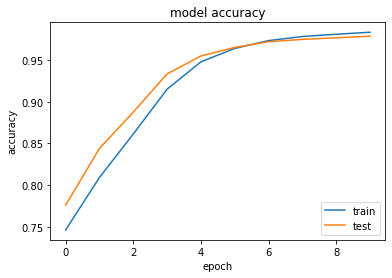

In [ ]:
# visualise training history
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## Evaluating models

Next we evaluate our models on test data.

Multiclass Linear Regression model

In [ ]:
loss, accuracy = lr_model.evaluate(Xtest, Ytest, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

63/63 [==============================] - 1s 11ms/step - loss: 1.0415 - acc: 0.8469
Loss: 1.0415045022964478,
Accuracy: 0.8469248414039612


RNN_1 model

In [ ]:
loss, accuracy = rnn_model_1.evaluate(Xtest, Ytest, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

63/63 [==============================] - 1s 22ms/step - loss: 1.2057 - acc: 0.8491
Loss: 1.2056972980499268,
Accuracy: 0.8491295576095581


RNN_2 model

In [ ]:
loss, accuracy = rnn_model_2.evaluate(Xtest, Ytest, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

63/63 [==============================] - 1s 13ms/step - loss: 1.2304 - acc: 0.8502
Loss: 1.2304353713989258,
Accuracy: 0.850174605846405


GRU model

In [ ]:
loss, accuracy = gru_model.evaluate(Xtest, Ytest, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

63/63 [==============================] - 1s 19ms/step - loss: 1.2228 - acc: 0.8500
Loss: 1.2227652072906494,
Accuracy: 0.8499515652656555


LSTM model

In [ ]:
loss, accuracy = lstm_model.evaluate(Xtest, Ytest, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

63/63 [==============================] - 2s 30ms/step - loss: 1.0841 - acc: 0.8488
Loss: 1.0840632915496826,
Accuracy: 0.8487791419029236


The RNN model with GLoVe pretrained word embedding performs the best on the test set. It is also faster than GRU and LSTM models.